# DAE

In [2]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.nn import functional as F
from skimage.measure import compare_ssim as ssim
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Setting up the arguments

In [3]:
class Arguments:
    def __init__(self,batch_size,data_path,center_fractions,accelerations,challenge,sample_rate,resolution):
        self.batch_size = batch_size
        self.data_path = data_path
        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.challenge = challenge
        self.sample_rate = sample_rate
        self.resolution = resolution
        
args=Arguments(1,'DATA',[0.08, 0.04],[4, 8],'singlecoil',1.,320)

### Custom dataset class

In [4]:
import pathlib
import random

import h5py
from torch.utils.data import Dataset


class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(self, root, transform, challenge, sample_rate=1):
        """
        Args:
            root (pathlib.Path): Path to the dataset.
            transform (callable): A callable object that pre-processes the raw data into
                appropriate form. The transform function should take 'kspace', 'target',
                'attributes', 'filename', and 'slice' as inputs. 'target' may be null
                for test data.
            challenge (str): "singlecoil" or "multicoil" depending on which challenge to use.
            sample_rate (float, optional): A float between 0 and 1. This controls what fraction
                of the volumes should be loaded.
        """
        if challenge not in ('singlecoil', 'multicoil'):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        self.transform = transform
        self.recons_key = 'reconstruction_esc' if challenge == 'singlecoil' \
            else 'reconstruction_rss'

        self.examples = []
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            kspace = h5py.File(fname, 'r')['kspace']
            num_slices = kspace.shape[0]
            self.examples += [(fname, slice) for slice in range(num_slices)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        with h5py.File(fname, 'r') as data:
            kspace = data['kspace'][slice]
            target = data[self.recons_key][slice] if self.recons_key in data else None
            return self.transform(kspace,fname.name,target)


### Data Transform (return original and masked kspace)

In [5]:
from data import transforms
class DataTransform:
    """
    Data Transformer for training DAE.
    """

    def __init__(self, mask_func, use_seed=True):
        self.mask_func = mask_func
        self.use_seed = use_seed

    def __call__(self, kspace, fname, target):
        original_kspace = transforms.to_tensor(kspace)
        # Apply mask
        seed = None if not self.use_seed else tuple(map(ord, fname))
        masked_kspace, mask = transforms.apply_mask(original_kspace, self.mask_func, seed)
        
         # Inverse Fourier Transform to get zero filled solution
        image = transforms.ifft2(masked_kspace)
        # Crop input image
        image = transforms.complex_center_crop(image, (args.resolution, args.resolution))
        # Absolute value
        image = transforms.complex_abs(image)
        # Apply Root-Sum-of-Squares if multicoil data
        if args.challenge == 'multicoil':
            image = transforms.root_sum_of_squares(image)
        # Normalize input
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        
        target = transforms.to_tensor(target)
        # Normalize target
        target = transforms.normalize(target, mean, std, eps=1e-11)
        target = target.clamp(-6, 6)
        
        return original_kspace, masked_kspace, target, mask

### Creating data loaders

In [6]:
from common.subsample import MaskFunc
from torch.utils.data import DataLoader
def create_datasets(args):
    train_mask = MaskFunc(args.center_fractions, args.accelerations)
    dev_mask = MaskFunc(args.center_fractions, args.accelerations)

    train_data = SliceData(
        root='DATA/singlecoil_train',
        transform=DataTransform(train_mask),
        sample_rate=args.sample_rate,
        challenge=args.challenge
    )
    dev_data = SliceData(
        root='DATA/singlecoil_val',
        transform=DataTransform(dev_mask, use_seed=True),
        sample_rate=args.sample_rate,
        challenge=args.challenge,
    )
    return dev_data, train_data


def create_data_loaders(args):
    dev_data, train_data = create_datasets(args)
    
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True, 
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        pin_memory=True,
    )
    return train_loader, dev_loader

train_loader, dev_loader = create_data_loaders(args)    

#### Some utility function

In [7]:
import matplotlib.pyplot as plt

def kspacetononcroppedimage(kspace):
    # Inverse Fourier Transform to get zero filled solution
    image = transforms.ifft2(kspace)
        # Absolute value
    return image

def kspacetoimage(kspace):
    # Inverse Fourier Transform to get zero filled solution
    image = transforms.ifft2(kspace)
        # Crop input image
    image = transforms.complex_center_crop(image, (args.resolution, args.resolution))
        # Absolute value
    image = transforms.complex_abs(image)
        # Apply Root-Sum-of-Squares if multicoil data
    if args.challenge == 'multicoil':
        image = transforms.root_sum_of_squares(image)
        # Normalize input
    image, mean, std = transforms.normalize_instance(image, eps=1e-11)
    image = image.clamp(-6, 6)

    return image

def plotimage(image):
    plt.imshow(np.array(image))
    plt.show()
    
def transformshape(kspace):
    s = kspace.shape
    kspace = np.reshape(kspace , (s[0],s[3],s[1],s[2]))
    s = kspace.shape
    if (s[3]/2)%2==1:
        npad = ((0, 0), (0, 0), (0, 0), (1, 1))
        kspace = np.pad(kspace, pad_width=npad, mode='constant', constant_values=0)
    if isinstance(kspace, np.ndarray):
        kspace = transforms.to_tensor(kspace)
    return kspace

def transformback(kspace):
    s = kspace.shape
    kspace = np.reshape(kspace , (s[0],s[2],s[3],s[1]))
    return kspace

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compare_images(imageA, imageB, title):
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    fig = plt.figure()
    plt.suptitle(title+" MSE: %.2f, SSIM: %.2f" % (m, s))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")

    plt.show()

def compareimageoutput(target,masked_kspace,outputkspace,mask):
    unmask = np.where(mask==1.0, 0.0, 1.0)
    unmask = transforms.to_tensor(unmask)
    unmask = unmask.float()
    output = transformback(outputkspace.data.cpu())
    output = output * unmask 
    output = output + masked_kspace.data.cpu()
    compare_images(np.array(target)[0],np.array(kspacetoimage(output))[0],'Target vs network output')
    compare_images(np.array(target)[0],np.array(kspacetoimage(masked_kspace.data.cpu()))[0],'Target vs zero imputed data')

def normalize(masked_data):
    image = transforms.ifft2(masked_data)
    nimage, mean, std = transforms.normalize_instance(image, eps=1e-11)
    nmasked_data = transforms.fft2(image)
    return transforms.to_tensor(nmasked_data).float()

def denormalize(outputdata, mean, std):
    image = transforms.ifft2(outputdata)
    image = transforms.normalize(image, mean, std, eps=1e-11)
    dnoriginal_data = transforms.fft2(image)
    return transforms.to_tensor(dnoriginal_data).float()

**The Denoising Autoencoder**

In [8]:
learning_rate = 0.001
epoch = 10
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 640 x 372 x 2 (input)  476160 activations
        #Conv2d(in_channels, out_channels, kernel_size,padding) 
        self.conv1e = nn.Conv2d(2, 14, 51, padding=25)        # 640 x 372 x 14
        self.conv2e = nn.Conv2d(14, 28, 51, padding=25)       # 640 x 372 x 28
        self.mpl1   = nn.MaxPool2d(2, return_indices=True)  # 320 x 186 x 28
        self.conv3e = nn.Conv2d(28, 56, 51, padding=25)       # 320 x 186 x 56
        self.mpl2   = nn.MaxPool2d(2, return_indices=True)  # 160 x 93 x 56     833280 activations
        
        self.conv4d = nn.ConvTranspose2d(56, 28, 51, padding=25)            # 320 x 186 x 28
        self.conv5d = nn.ConvTranspose2d(28, 14, 51, padding=25)            # 640 x 372 x 14   
        self.conv6d = nn.ConvTranspose2d(14, 2, 51, padding=25)             # 640 x 372 x 2
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.leaky_relu(x)
        
        x = self.conv2e(x)
        x = F.leaky_relu(x)
        
        x, i = self.mpl1(x)
        
        x = self.conv3e(x)
        x = F.leaky_relu(x)
        
        x, j = self.mpl2(x)
        
        # Decoder
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv4d(x)
        x = F.leaky_relu(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv5d(x)
        x = F.leaky_relu(x)
        
        x = self.conv6d(x)
        x = F.leaky_relu(x)
        
        return x

autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [16]:
train_loss = []
valid_loss = []
print('Total number of epochs:', epoch)
print('Total number of training iterations: ',len(train_loader))
print('Total number of validation iterations: ',len(dev_loader))


for i in range(epoch):
    print("Epoch: ",i)
    # model training
    total_loss = 0.0
    total_iter = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        original_kspace,masked_kspace,target, mask = data
        original_width = original_kspace.shape[2]
        #noriginal_kspace,nmasked_kspace = normalize(original_kspace),normalize(masked_kspace)
        noriginal_kspace,nmasked_kspace = transformshape(original_kspace), transformshape(masked_kspace) 
        
        noriginal_kspace = Variable(noriginal_kspace).cuda()
        nmasked_kspace = Variable(nmasked_kspace).cuda()
        optimizer.zero_grad()
        
        outputkspace = autoencoder(nmasked_kspace)
        
        if outputkspace.shape[3]==original_kspace.shape[2]:
            loss = loss_func(outputkspace, noriginal_kspace)
        else:
            loss = loss_func(outputkspace[:,:,:,1:1+original_width], noriginal_kspace[:,:,:,1:1+original_width])
        print(loss.data.item())
        loss.backward()
        optimizer.step()
        
        total_iter += 1
        total_loss += loss.data.item()
        if total_iter%1000 == 0:
            print('Training loss: ',total_loss / total_iter, ' iterations :', total_iter)
            compareimageoutput(target,masked_kspace,outputkspace,mask)
            break
        
    break    
    train_loss.append(total_loss / total_iter)    
    print('Total training loss: ', train_loss[-1])
    # validation loss
    
    total_val_loss = 0.0
    total_val_iter = 0
    autoencoder.eval()
    for i,data in enumerate(dev_loader):
        original_kspace,masked_kspace,target, mask = data
        original_width = original_kspace.shape[2]
        
        inputdata = Variable(transformshape(original_kspace)).cuda()
        masked_kspace = Variable(transformshape(masked_kspace)).cuda()
        
        outputdata = autoencoder(masked_kspace)
        
        loss = loss_func(outputdata[:,:,:,1:1+original_width], inputdata[:,:,:,1:1+original_width])
        
        total_val_iter += 1
        total_val_loss += loss.data.item()
        if total_val_iter%1000 == 0:
            print('Validation loss: ',total_val_loss / total_val_iter, ' iterations :', total_val_iter)
    
    valid_loss.append(total_val_loss / total_val_iter)
    print('Total validation loss: ', train_loss[-1])
    

Total number of epochs: 10
Total number of training iterations:  34742
Total number of validation iterations:  7135
Epoch:  0
1.4618512068409473e-05
156.2314910888672
9.113549914729902e-10
1.6166308292042686e-09


KeyboardInterrupt: 

# The code below is just for person use (inference and testing)

In [61]:
np.savetxt('originalkspace_a.txt', original_kspace[0,:,:,0])
np.savetxt('originalkspace_b.txt', original_kspace[0,:,:,1])

In [ ]:
i = original_kspace[0,:,:,0]
p = original_kspace[0,:,:,1]
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = noriginal_kspace[0,0,:,:]
p = noriginal_kspace[0,1,:,:]
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = masked_kspace[0,0,:,:].data.cpu()
p = masked_kspace[0,1,:,:].data.cpu()
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

i = nmasked_kspace[0,0,:,:].data.cpu()
p = nmasked_kspace[0,1,:,:].data.cpu()
plt.plot(np.array(i))
plt.show()
plt.plot(np.array(p))
plt.show()

In [18]:
np.sum(np.array(original_kspace[0,:,:,0]) == 0)

23040

Epoch:  0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


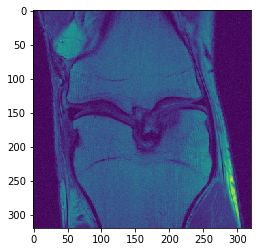

In [9]:
for i in range(epoch):
    print("Epoch: ",i)
    # model training
    total_loss = 0.0
    total_iter = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        original_kspace,masked_kspace,target, mask = data
        #noriginal_kspace,nmasked_kspace = normalize(original_kspace),normalize(masked_kspace)
        original_width = original_kspace.shape[2]
        
        inputdata = Variable(transformshape(original_kspace)).cuda()
        masked_kspace = Variable(transformshape(masked_kspace)).cuda()
        optimizer.zero_grad()
        
        outputdata = autoencoder(masked_kspace)
        plotimage(kspacetoimage(original_kspace)[0])
        break
    break

In [ ]:
unmask = np.where(mask==1.0, 0.0, 1.0)
unmask = transforms.to_tensor(unmask)
unmask = unmask.float()
output = transformback(outputkspace.data.cpu())

list(autoencoder.parameters())

list(autoencoder.parameters())

train_loss = []
valid_loss = []
print('Total number of epochs:', epoch)
print('Total number of training iterations: ',len(train_loader))
print('Total number of validation iterations: ',len(dev_loader))

for i in range(epoch):
    print("Epoch: ",i)
    # model training
    total_loss = 0.0
    total_iter = 0

    autoencoder.train()
    for i,data in enumerate(train_loader):
        original_kspace,masked_kspace,target, mask = data
        original_width = original_kspace.shape[2]
        
        inputdata = Variable(transformshape(original_kspace)).cuda()
        masked_kspace = Variable(transformshape(masked_kspace)).cuda()
        optimizer.zero_grad()
        
        outputdata = autoencoder(masked_kspace)
        plotimage(kspacetoimage(original_kspace))
        break
    break

plt.plot(np.unique(np.array(noriginal_kspace.data.cpu())))

np.unique(np.array(outputkspace.data.cpu()))

outputkspace = autoencoder(nmasked_kspace)

loss_func(outputkspace, noriginal_kspace)

compareimageoutput(target,masked_kspace,outputkspace,mask)

In [ ]:
plotimage(kspacetoimage(transforms.to_tensor(transformback(transformshape(outputdata)[:,:,:,1:1+original_width]))))
max=0
v=0
for i,data in enumerate(train_loader):
    original_kspace,masked_kspace,target, mask = data
    s = original_kspace.shape
    if s[2]>max:
        max = s[2]
        v = s
print(max)
print(v)
plt.imshow(np.array(masked_kspace[0,250:400,150:250,0]))
plt.show()
plt.imshow(np.array(original_kspace[0,250:400,150:250,0]))
plt.show()
print(np.array(mask).shape)

In [ ]:
# Save the model
torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import random

img, _ = random.choice(cifar10_valid)
img    = img.resize_((1, 3, 32, 32))
noise  = torch.randn((1, 3, 32, 32)) * noise_level
img_n  = torch.add(img, noise)

img_n = Variable(img_n).cuda()
denoised = autoencoder(img_n)


show_img(img[0].numpy(), img_n[0].data.cpu().numpy(), denoised[0].data.cpu().numpy())

# Visualize the first image of the last batch in our validation set
    orig = image[0].cpu()
    noisy = image_n[0].cpu()
    denoised = output[0].cpu()

    orig = orig.data.numpy()
    noisy = noisy.data.numpy()
    denoised = denoised.data.numpy()

    print("Iteration ", i+1)
    show_img(orig, noisy, denoised)

In [ ]:
learning_rate = 0.001
epoch = 10
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 640 x 372 x 2 (input)  476160 activations
        self.conv1e = nn.Conv2d(2, 24, 3, padding=2)        # 640 x 372 x 24
        self.conv2e = nn.Conv2d(24, 48, 3, padding=2)       # 640 x 372 x 48
        self.conv3e = nn.Conv2d(48, 96, 3, padding=2)       # 640 x 372 x 96
        self.conv4e = nn.Conv2d(96, 128, 3, padding=2)      # 640 x 372 x 128
        self.conv5e = nn.Conv2d(128, 256, 3, padding=2)     # 640 x 372 x 256
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)  # 640 x 372 x 256       60948480 acivations

        self.mp1d = nn.MaxUnpool2d(2)
        self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
        self.conv4d = nn.ConvTranspose2d(128, 96, 3, padding=2)
        self.conv3d = nn.ConvTranspose2d(96, 48, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(24, 3, 2, padding=2)
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)
        x = self.conv4e(x)
        x = F.relu(x)
        x = self.conv5e(x)
        x = F.relu(x)
        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv5d(x)
        x = F.relu(x)
        x = self.conv4d(x)
        x = F.relu(x)
        x = self.conv3d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv1d(x)
        x = F.relu(x)
        
        return x

autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

self.conv1e = nn.Conv2d(2, 14, 3, padding=1)        # 640 x 372 x 14
        self.conv2e = nn.Conv2d(14, 28, 3, padding=1)       # 640 x 372 x 28
        self.mpl1   = nn.MaxPool2d(2, return_indices=True)  # 320 x 186 x 28
        self.conv3e = nn.Conv2d(28, 56, 3, padding=1)       # 320 x 186 x 56
        self.mpl2   = nn.MaxPool2d(2, return_indices=True)  # 160 x 93 x 56     833280 activations
        
        self.conv4d = nn.ConvTranspose2d(56, 28, 3, padding=1)            # 320 x 186 x 28
        self.conv5d = nn.ConvTranspose2d(28, 14, 3, padding=1)            # 640 x 372 x 14   
        self.conv6d = nn.ConvTranspose2d(14, 2, 3, padding=1)             # 640 x 372 x 2
        
        def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        
        x = self.conv2e(x)
        x = F.relu(x)
        
        x, i = self.mpl1(x)
        
        x = self.conv3e(x)
        x = F.relu(x)
        
        x, j = self.mpl2(x)
        
        # Decoder
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv4d(x)
        x = F.relu(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.conv5d(x)
        x = F.relu(x)
        
        x = self.conv6d(x)
        x = F.relu(x)
        
        return x

def explainmasking():
    masked = original_kspace*mask
    maskedt = original_kspace*unmask
    total = masked + maskedt
    plotimage(kspacetoimage(masked))
    plotimage(kspacetoimage(maskedt))
    plotimage(kspacetoimage(total))